In [59]:
import faiss
import tasks.image as image
from project.indexer.mongo import client, db

index = faiss.read_index('./data/models.idx')

def getEmbeddingIndexMap(indexName):
    coll = db['%s-embs' % indexName]
    return list(coll.find({}, {"_id": 0, "doc": 1}))

def extractFace(url):
    fn = image.saveImage(url)
    return image.modelFaceAnalysis(fn)

embeddingMap = getEmbeddingIndexMap("pixs-models")

def getDocsFromIndices(indices):
    docs = []
    for i in indices:
        docs.append(embeddingMap[i]["doc"])
    return docs

def analyseSingleFace(face, k):
    resutlIndices = index.search(np.asarray([face["embedding"]]), k)
    del face["embedding"]
    return {
        "analysis": face,
        "result": getDocsFromIndices(resutlIndices[1][0]),
        "distance": resutlIndices[0][0].tolist()
    }

def analyseFacesInImg(url, k):
    faces = extractFace(url)
    resutls = []
    for face in faces:
        result = analyseSingleFace(face, k)
        resutls.append(result)
    return {
        "results": resutls,
        "url": url
    }

In [108]:
import ipyplot
import tasks.image as image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plotImagesRowFromResult(res):
    imgData = res["result"]
    imgUrls = list(map(lambda a: a["imgUrl"], imgData))
    labels = list(map(lambda a: a["name"], imgData))
    ipyplot.plot_images(imgUrls, labels, img_width=150)
    
def mathplGetImg(url):
    filename = image.saveImage(url)
    return plt.imread(filename)

def plotResult(results):
    fig, ax = plt.subplots()
    ax.imshow(mathplGetImg(results["url"]))
    
    i = 0
    for face in results["results"]:
        box = face["analysis"]["box"]
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.annotate('%i' % i, (box[0], box[1]), color='red', weight='bold', fontsize=15)
        ax.add_patch(rect)
        i+=1

    plt.show()

    for result in results["results"]:
        plotImagesRowFromResult(result)

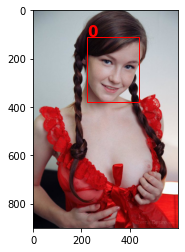

In [125]:
results = analyseFacesInImg("https://k5x5n5g8.ssl.hwcdn.net/content/170230/0695-01_w600.jpg", 5)
plotResult(results)
